# **The Science Behind a Good Wine: Exploring Key Chemical Drivers**

## 1. Introduction

This analysis investigates which measurable chemical properties most influence red wine quality, helping winemakers focus on what truly matters during production.

### Goal

To help wine producers understand which measurable chemical properties most influence perceived wine quality, and to identify where to focus production efforts for consistently higher-rated wines.

### Key Questions

1. Does higher alcohol content improve perceived wine quality?

2. Does higher volatile acidity reduce wine quality?

3. Do higher sulphate levels correlate with higher quality?

4. Which chemical features have little or no impact on quality?

### Structure

1. Introduction
2. Initial Data Overview
3. Hypotheses Formulation
4. Initial EDA
5. Data Cleaning & Outlier Inspection
6. Post-Cleaning EDA
7. Feature Correlation
8. Identifying Skewness and Transforming Features
9. Scaling
10. OLS Base Model
11. OLS Base Model Evaluation On The Test Set
12. Improving Linearity with Polynomial Feature Interactions
13. Test Set Evaluation — Polynomial Interaction Model
14. Comparing Both Models
15. Final Analysis Summary & Recommendations
16. Analysis Limitations & Suggestions for Improvement

## 2. Initial Data Overview

Importing libraries :

In [1]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch

# Scientific and statistical libraries
import scipy.stats as stats
from scipy.stats import boxcox, skew, shapiro
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    mean_squared_error,
    r2_score,
    mean_absolute_error,
)

# Statsmodels
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

# Visualization
import seaborn as sns

# Custom local functions
from CustomFunctionsWineAnalysis import (
    plot_feature_histograms,
    plot_feature_violins_by_skew,
    plot_feature_vs_target_boxplots,
    clean_and_cap_outliers,
    plot_combined_boxplots_comparison,
    plot_correlation_heatmap,
    calculate_vif,
    transform_skewed_features,
    plot_significant_coefficients,
    plot_qq_residuals,
    prepare_polynomial_features,
    plot_significant_coefficients_poly,
    compare_model_predictions,
)

Loading the red wine quality dataset:

In [2]:
file_path = "winequality-red.csv"

df = pd.read_csv(file_path)

Previewing the data:

In [3]:
df.shape

(1599, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


**Results summary:** The dataset contains 1,599 red wine samples with 11 numerical features and 1 integer target variable (quality), and it has no missing values.

Finding out some statistics about the features:

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


**Results summary:** the dataset shows that red wine samples have moderate variability across features, with average alcohol content around 10.4%, average pH around 3.31, and most quality scores centered between 5 and 6.

### Understanding and previewing the dataset conclusion

The Red Wine Quality dataset contains 1,599 samples of Portuguese "Vinho Verde" red wines. Each sample is described by 11 physicochemical variables measured through laboratory tests and one sensory variable — a quality score assigned by professional wine tasters on a scale from 0 to 10. 

The physicochemical features include:

**1. Fixed acidity (g/dm³):** Tartaric acid content.

**2. Volatile acidity (g/dm³):** Acetic acid content, affecting vinegar taste.

**3. Citric acid (g/dm³):** Citric acid content, contributing to wine freshness.

**4. Residual sugar (g/dm³):** Remaining sugar after fermentation.

**5. Chlorides (g/dm³):** Salt content.

**6. Free sulfur dioxide (mg/dm³):** Free form of SO₂ protecting wine from microbes.

**7. Total sulfur dioxide (mg/dm³):** Total amount of SO₂.

**8. Density (g/cm³):** Mass-to-volume ratio of wine, closely related to alcohol and sugar content.

**9. pH:** Acidity level (lower pH means more acidic).

**10. Sulphates (g/dm³):** Sulphate levels, contributing to microbial stability and taste.

**11. Alcohol (% vol):** Alcohol content by volume.

The quality score is a subjective evaluation based on sensory criteria like taste, aroma, and overall impression.
The data was collated by physicochemical testing and sensory analysis, referenced in the paper by Cortez et al. (2009), as part of research aimed at identifying how chemical properties influence perceived wine quality. There are no missing values in the dataset, and all attributes are numeric.

On average, wines in the dataset have an alcohol content of 10.4%, a pH of 3.31, and quality scores mostly centered around 5 to 6.

## 3. Hypotheses Formulation

### Hypothesis 1 : Alcohol and quality connection

Alcohol is often perceived to improve mouthfeel and warmth — tasters may rate higher-alcohol wines better. It’s a consistently strong variable in wine studies.

**H₁:** Higher alcohol content is positively associated with higher wine quality.

**H₀:**  Alcohol content has no association with wine quality.

### Hypothesis 2: Volatile acidity and quality

 Volatile acidity contributes to vinegar-like taste. If it’s too high, wine is often downgraded by tasters.

**H₁:** Higher volatile acidity is negatively associated with wine quality.

**H₀:** Volatile acidity has no association with wine quality.

### Hypothesis 3: Sulphates and quality

Sulphates improve microbial stability and may enhance flavor preservation — higher levels might subtly improve quality.

**H₁:** Higher sulphate levels are positively associated with wine quality.

**H₀:** Sulphate levels have no association with wine quality.

These hypotheses are based on known oenological principles: alcohol often enhances mouthfeel and perceived warmth, while volatile acidity contributes to vinegar-like off-flavors. Both are continuous, measurable variables and suitable for linear regression modeling with statistical inference (p-values, confidence intervals).

## 4. Initial EDA

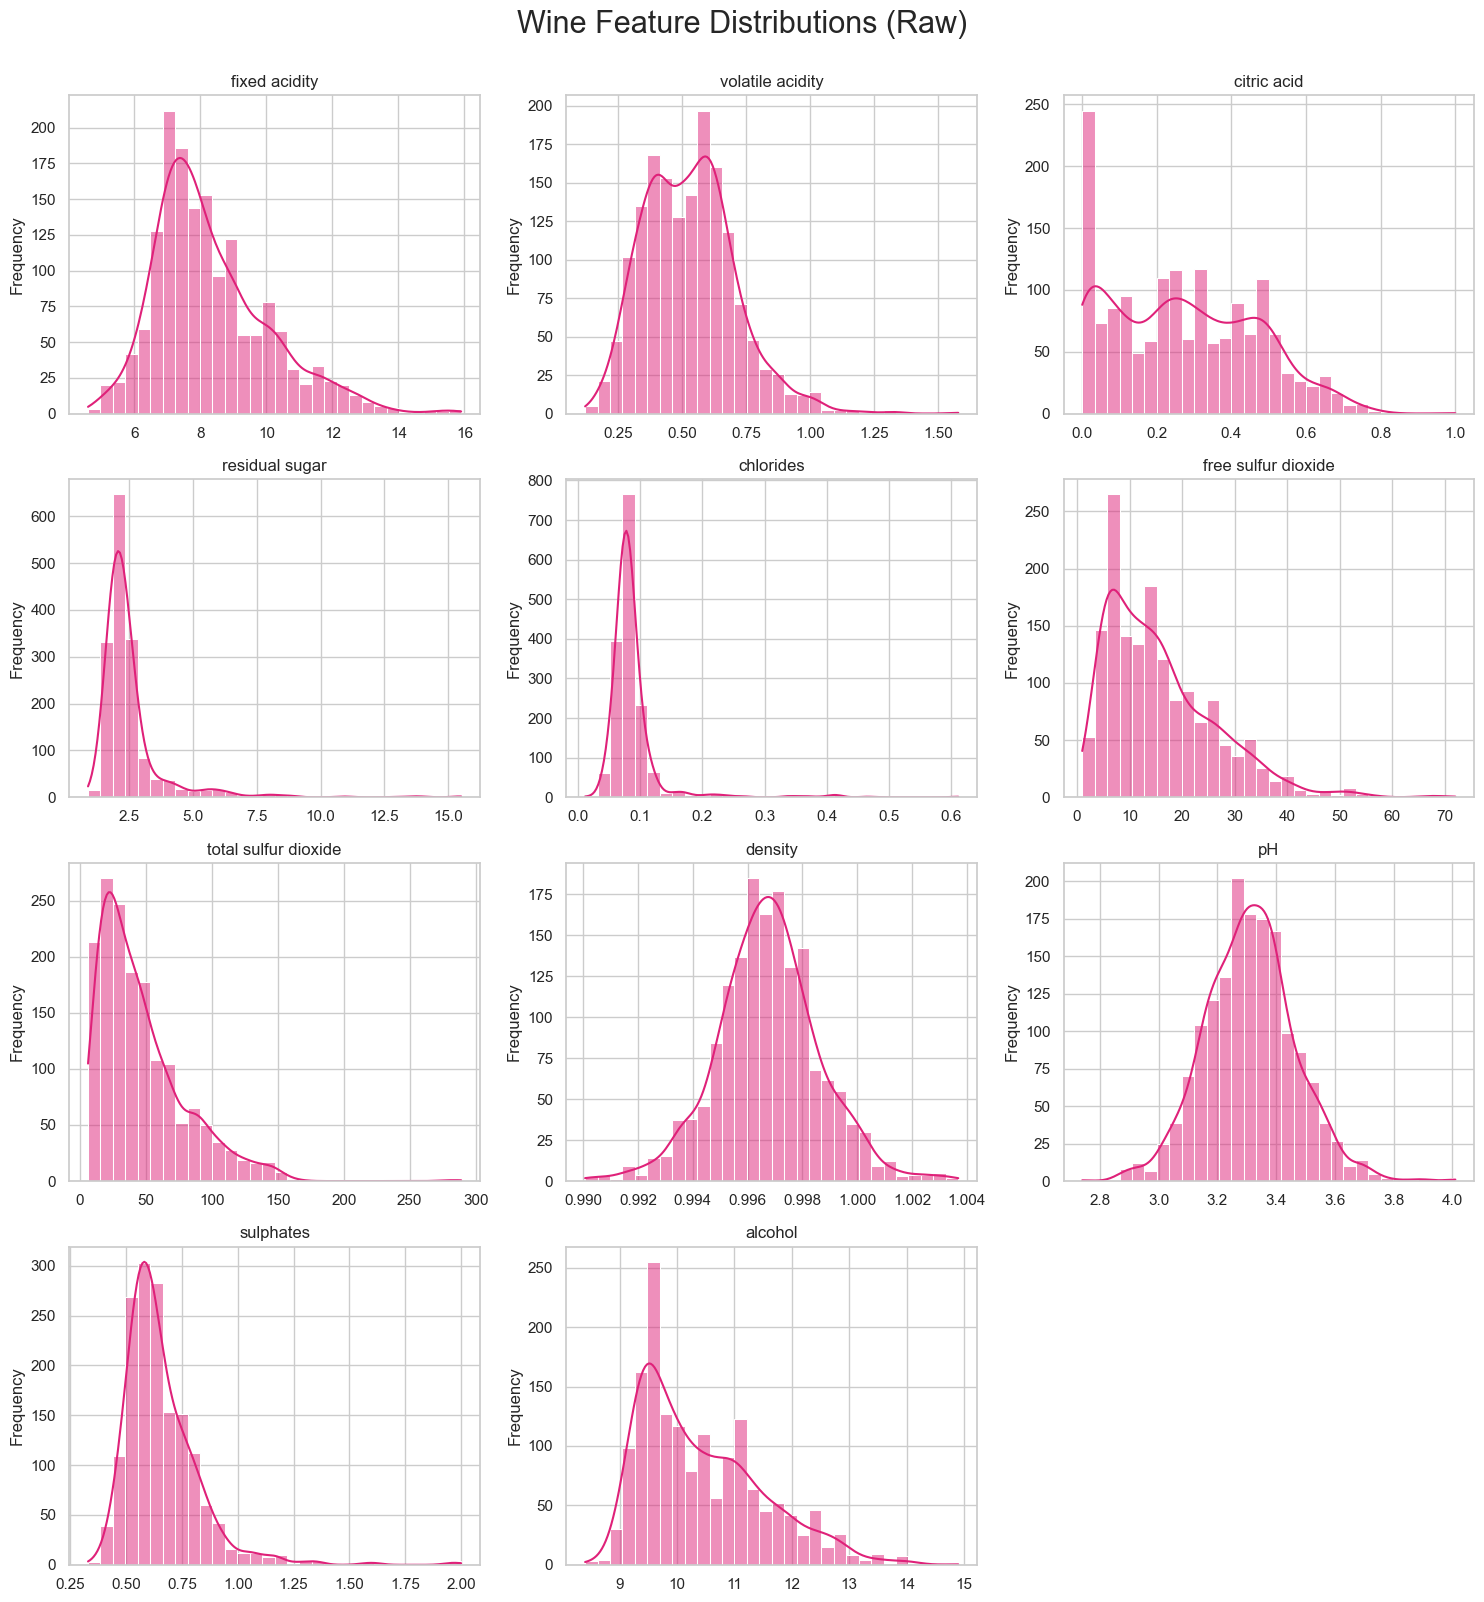

In [6]:
plot_feature_histograms(
    df, exclude_cols=["quality"], title="Wine Feature Distributions (Raw)"
)

**RESULTS SUMMARY:** most features are right-skewed, including **residual sugar**, **chlorides**, **sulphates**, and **total sulfur dioxide**, suggesting potential outliers or long tails.  

**Alcohol**, **fixed acidity**, and **pH** are more normally distributed, while **density** is tightly clustered.  
This initial inspection highlights the need for further cleaning and possibly applying transformations before modeling.

## 5. Data Cleaning & Outlier Inspection

### Dealing with duplicates

**PURPOSE:**
To ensure data quality by identifying repeated entries that could distort statistical analysis or model performance.

Getting all possible fully duplicated rows including their duplicates:

In [7]:
duplicated_full = df[df.duplicated(keep=False)]

Sorting to see them grouped:

In [8]:
duplicated_full_sorted = duplicated_full.sort_values(by=list(df.columns)).reset_index(
    drop=True
)

Checking the first few for manual inspection:

In [9]:
duplicated_full_sorted.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
1,5.2,0.34,0.00,1.8,0.050,27.0,63.0,0.99160,3.68,0.79,14.0,6
2,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5
3,5.6,0.50,0.09,2.3,0.049,17.0,99.0,0.99370,3.63,0.63,13.0,5
4,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4,5
5,5.6,0.54,0.04,1.7,0.049,5.0,13.0,0.99420,3.72,0.58,11.4,5
6,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
7,5.6,0.66,0.00,2.2,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7
8,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6
9,5.9,0.61,0.08,2.1,0.071,16.0,24.0,0.99376,3.56,0.77,11.1,6


I identified 240 fully duplicated rows in the dataset, meaning they had identical values across all features. Since there is no unique wine identifier, these rows may represent repeated entries rather than meaningful new observations. Keeping duplicates could introduce bias in our statistical models, especially in regression, where duplicated rows may overweight specific data points. Therefore, we removed them to maintain the assumption of independence in our analysis

Counting full duplicates:

In [10]:
n_duplicates = df.duplicated().sum()
print(f"Number of fully duplicated rows: {n_duplicates}")

Number of fully duplicated rows: 240


Removing full duplicates:

In [11]:
df = df.drop_duplicates().reset_index(drop=True)
print(f"New dataset shape: {df.shape}")

New dataset shape: (1359, 12)


**RESULTS SUMMARY:** I identified and removed 240 fully duplicated rows. These duplicates were exact copies across all variables and could bias statistical analysis by overweighting specific patterns. Removing them ensures each observation contributes equally to the model.

### Checking for missing values

**PURPOSE:**
To ensure data quality by identifying missing entries that could distort statistical analysis or model performance.

Check for missing values in each column:

In [12]:
missing_counts = df.isnull().sum()
print(missing_counts)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


No missing values were found in any column.

### Capping values

**PURPOSE:** to limit the influence of extreme outlier values by replacing them with a defined threshold, ensuring that the model is not distorted by rare or abnormal observations.

In [13]:
columns_to_cap = ["residual sugar", "chlorides", "sulphates", "total sulfur dioxide"]
df_cleaned = clean_and_cap_outliers(df, columns_to_cap)

Cleaned dataset shape: (1359, 12)


To reduce the influence of extreme values, we capped four highly skewed features at their 1st and 99th percentiles.
This approach preserves all rows but limits the range of outliers.

| Feature               | Min after capping | Max after capping |
|-----------------------|-------------------|-------------------|
| Residual sugar        | 1.40              | 8.30              |
| Chlorides             | 0.042             | 0.368             |
| Sulphates             | 0.430             | 1.280             |
| Total sulfur dioxide  | 8.00              | 145.84            |

These values reflect a more robust range, improving the reliability of downstream statistical analysis.

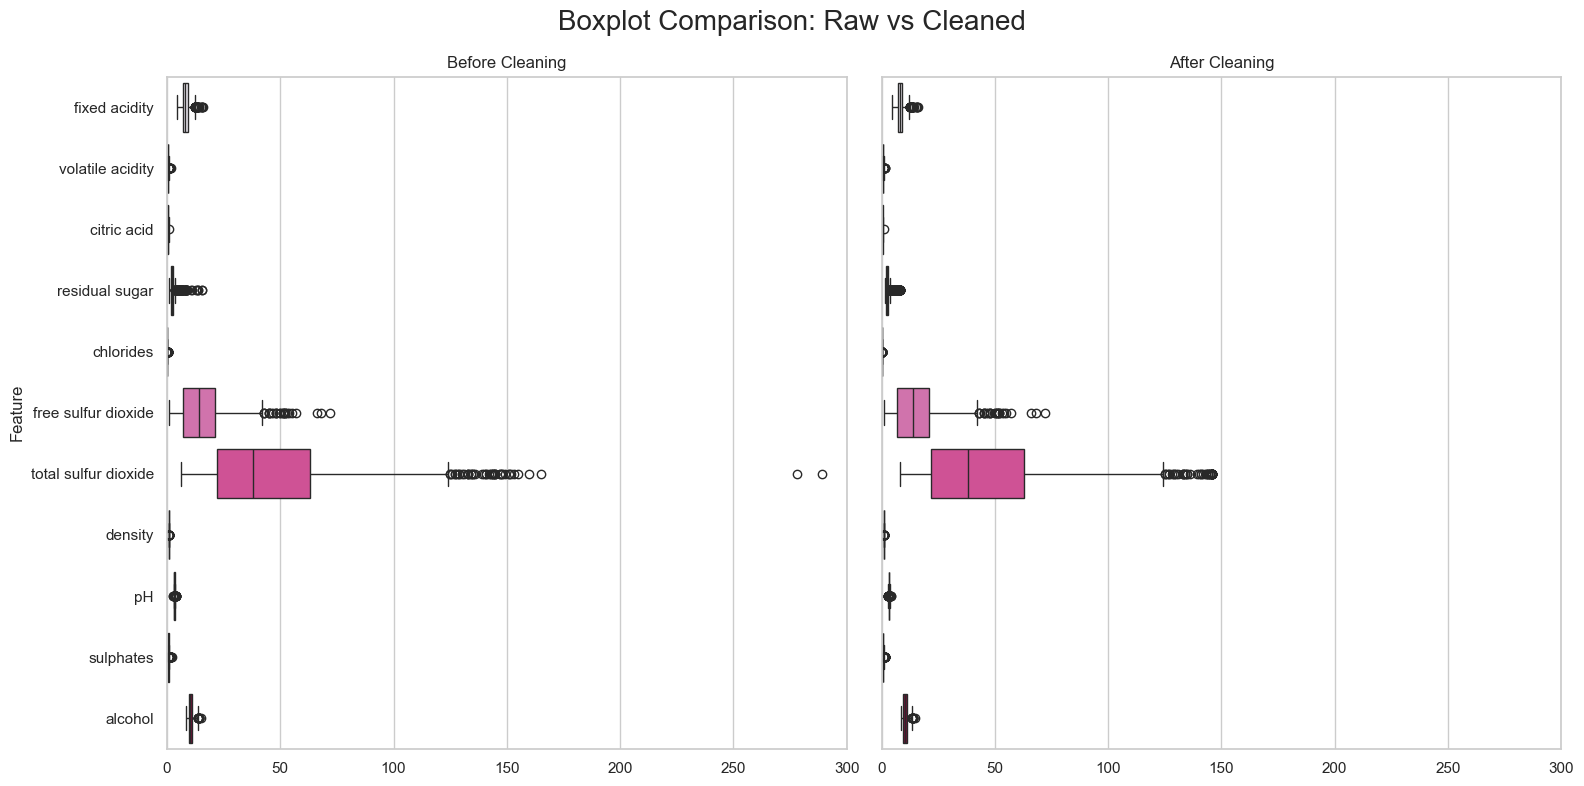

In [14]:
plot_combined_boxplots_comparison(
    df_raw=df, df_cleaned=df_cleaned, exclude_cols=["quality"]
)

**RESULTS SUMMARY:** 
1. Outliers in features like total sulfur dioxide, residual sugar, and chlorides were visibly reduced after cleaning, leading to tighter box ranges.

2. The cleaned dataset shows more symmetric and compact distributions, especially for features with heavy skew before (e.g., sulphates and chlorides).

3. Central tendencies (medians) remained largely unchanged, indicating that the core structure of the data was preserved.

4. This comparison confirms that outlier capping effectively removed extreme values without distorting feature distributions, improving model robustness.

## 6. Post-Cleaning EDA

### Wine Feature Distributions in a Violin Plots

**PURPOSE:** to assess the distribution and skewness of each numerical feature using violin plots, with color intensity mapped to the degree of skewness. This enhances interpretability by allowing quick visual detection of features with potential outliers or asymmetric distributions.

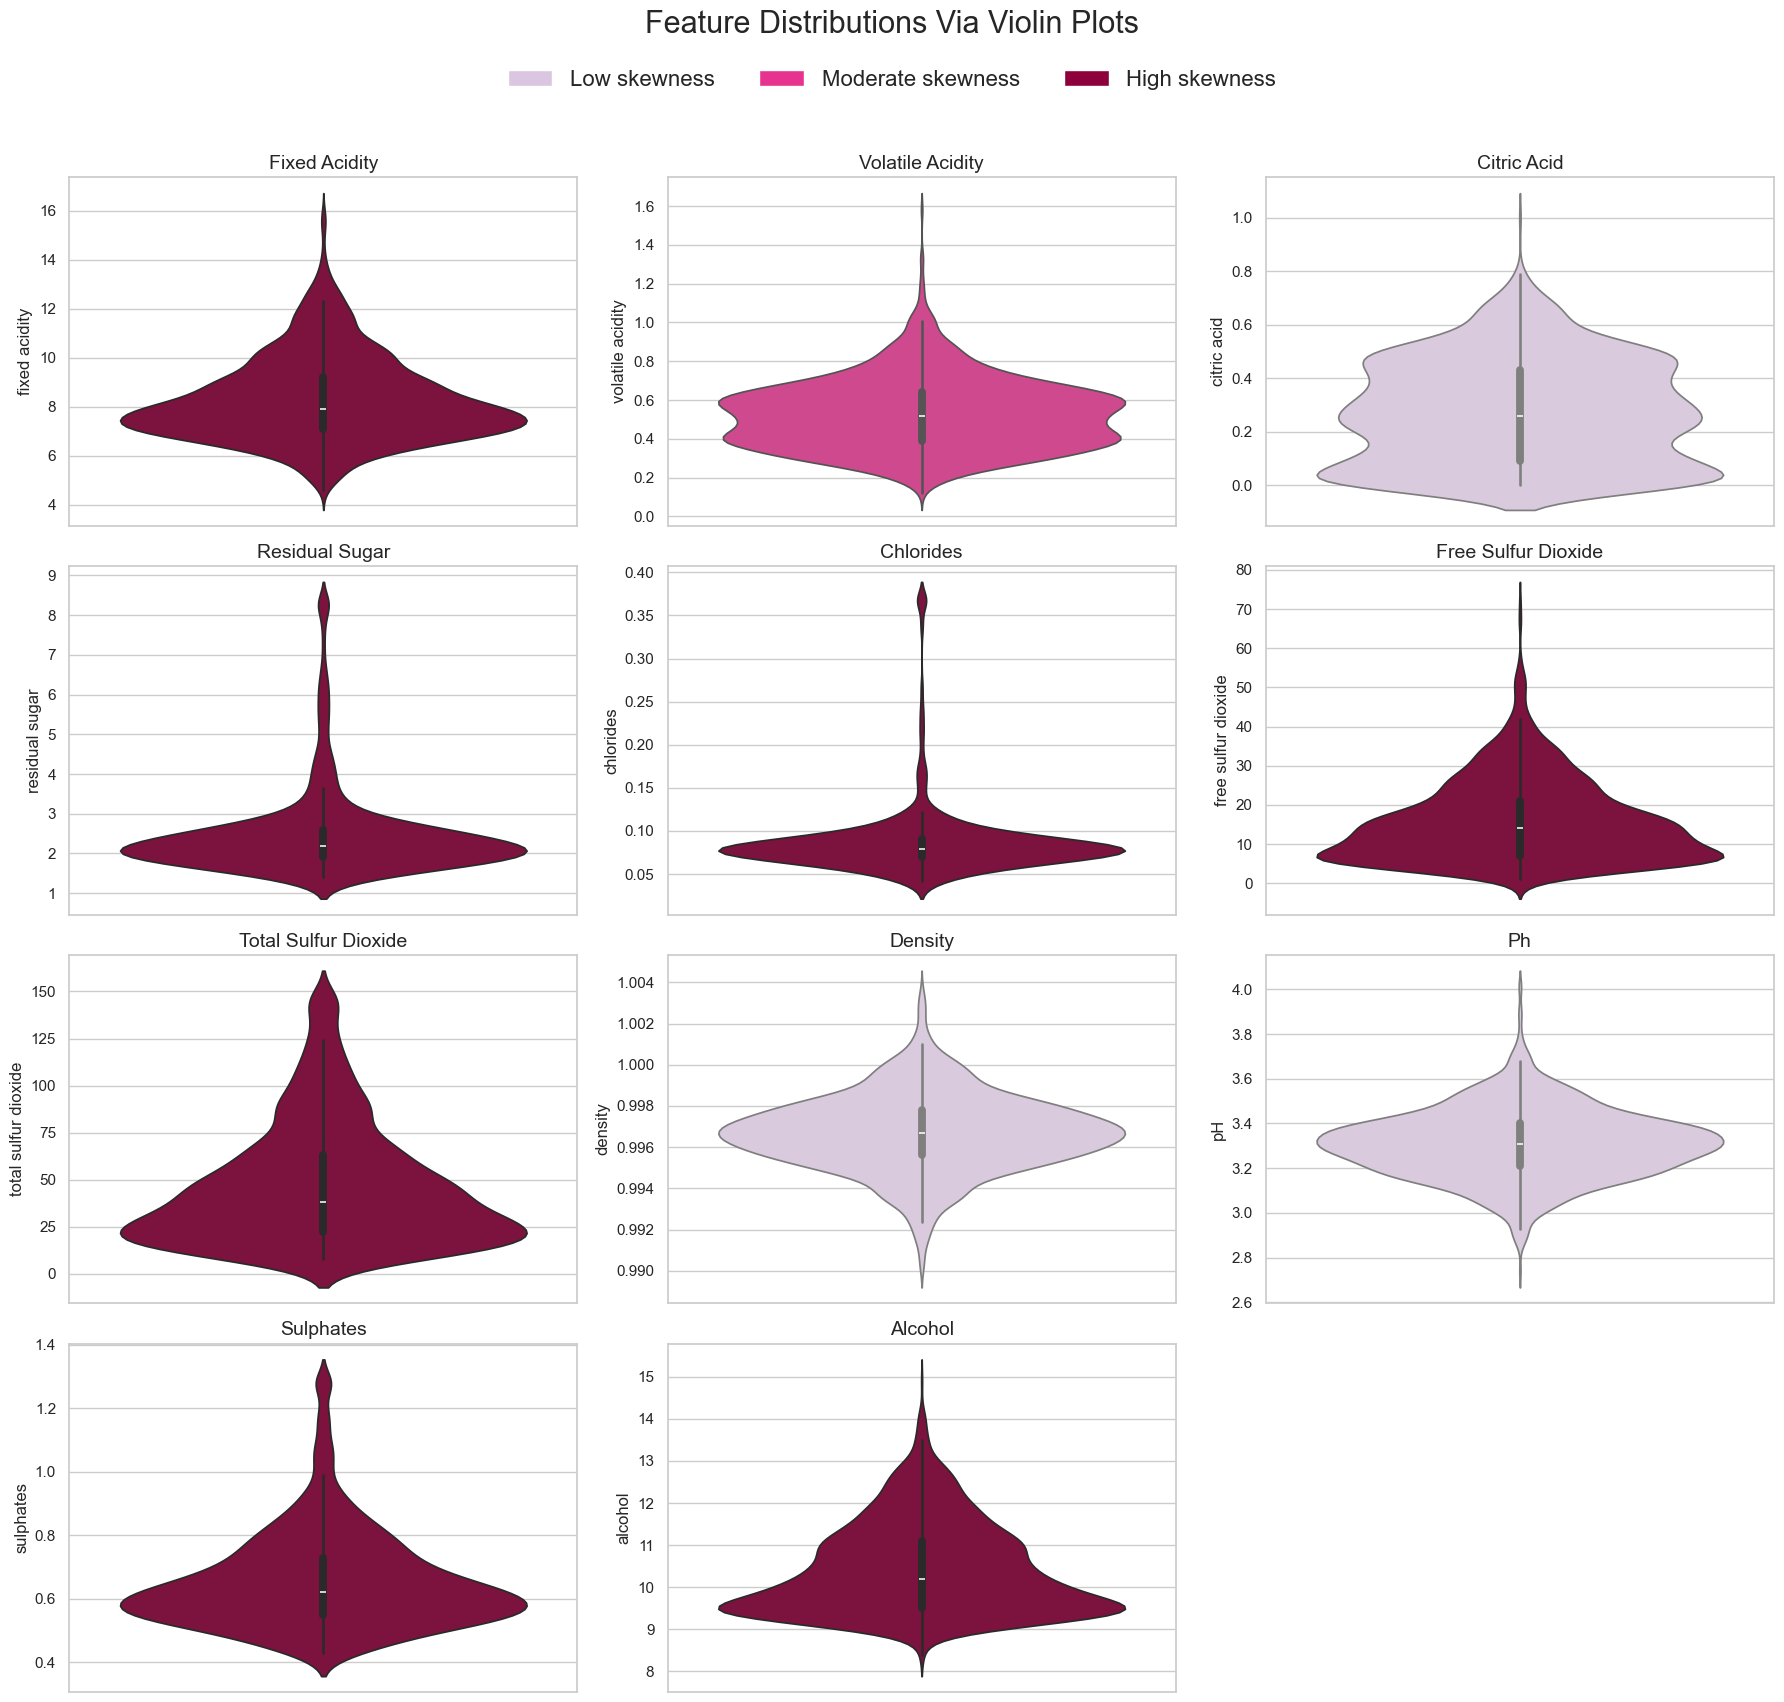

In [15]:
plot_feature_violins_by_skew(df_cleaned, exclude_cols=["quality"])

**RESULTS SUMMARY:** Distribution After Outlier Capping

- Features like chlorides and residual sugar are highly skewed meaning they contain extreme values (long tails) that may distort regression models, especially linear ones.

- A lot of other features indicates not so extreme, but still high skewness.

- Moderate skewness in fixed acidity suggests some asymmetry, which could still affect model assumptions.

- Features with low skewness (like pH or density) are well-behaved and likely need no transformation.

- This indicates that I will have to apply skewness-reducing transformations.

### Feature by Wine Quality

Next, let's compare Alcohol, Volatile Acidity, Sulphates amd other features by Wine Quality directly.

**PURPOSE:** Explore how one feature varies by target (quality) and if it supports analysis hypotheses.

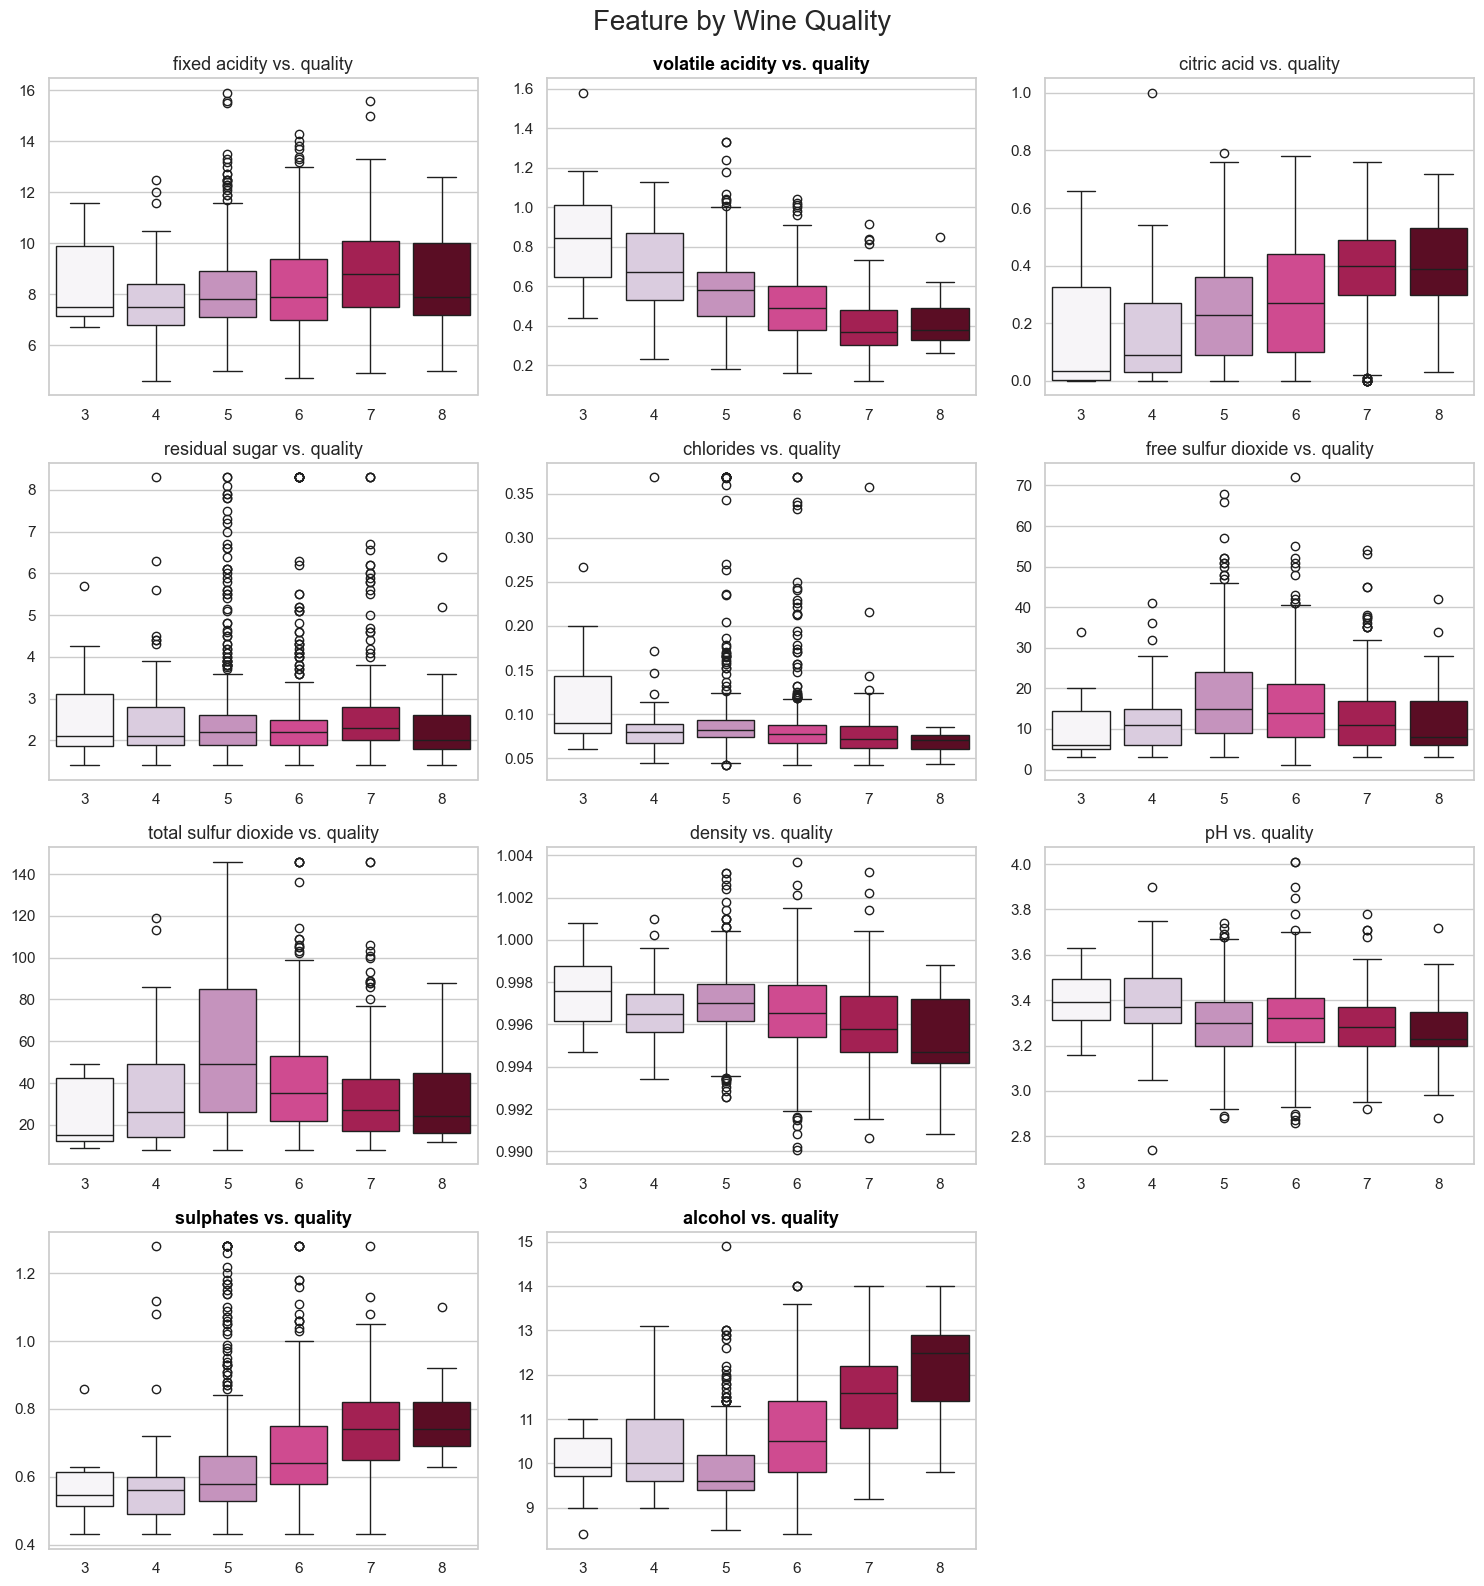

In [16]:
plot_feature_vs_target_boxplots(
    df_cleaned,
    title="Feature by Wine Quality",
    target="quality",
    highlight_features=["alcohol", "sulphates", "volatile acidity"],
)

**RESULTS SUMMARY:** 

1. Alcohol vs Wine Quality: clear positive relationship between alcohol content and wine quality.  
Higher quality wines tend to have higher alcohol levels, with quality 8 wines showing the highest median alcohol content.  

2. Violatile Acid vs Wine Quality:  a clear negative relationship is observed: wines with lower quality ratings (3–5) tend to have higher volatile acidity, while higher quality wines (7–8) show lower values and tighter distributions.

3. Sulphates vs Wine Quality: there is a modest positive relationship between sulphate levels and wine quality. While not as strong as with alcohol, the median sulphate content tends to increase slightly with quality, particularly at the higher end.

4. Features like pH and citric acid show overlapping distributions, suggesting weaker or nonlinear influence.

**INTERPRETATION:** 

1. Alcohol vs Wine Quality: This supports the Hypothesis 1, that alcohol is positively associated with perceived wine quality. Quality 3–5 wines cluster around lower alcohol values (around 9.5–10.5%).Quality 7 and 8 wines show higher medians and broader ranges, reaching up to 13–14%.
No overlap in medians between lowest and highest quality bins.

2. Violatile Acid vs Wine Quality: This supports Hypothesis 2 — that higher volatile acidity is negatively associated with wine quality.  
Lower quality wines (3–5) tend to have higher volatile acidity, whereas higher quality wines (7–8) show lower values with tighter variability.  
This suggests that excessive volatile acidity may reduce perceived wine quality.

3. Sulphates vs Wine Quality: This provides moderate support for Hypothesis 3 — that higher sulphate levels are positively associated with wine quality.  
A slight upward trend is visible, with higher quality wines showing slightly elevated sulphate levels.  
However, the relationship is less distinct compared to alcohol or volatile acidity.

## 7. Feature Correlation 

### Pearson Correlation Heatmap

The heatmap below shows pairwise correlations between all numeric features, including their relationships with wine quality.  

**PURPOSE:** It helps identify strongly related variables and potential multicollinearity before model fitting. 

- **Pearson correlation** measures the strength and direction of linear relationships between continuous variables.

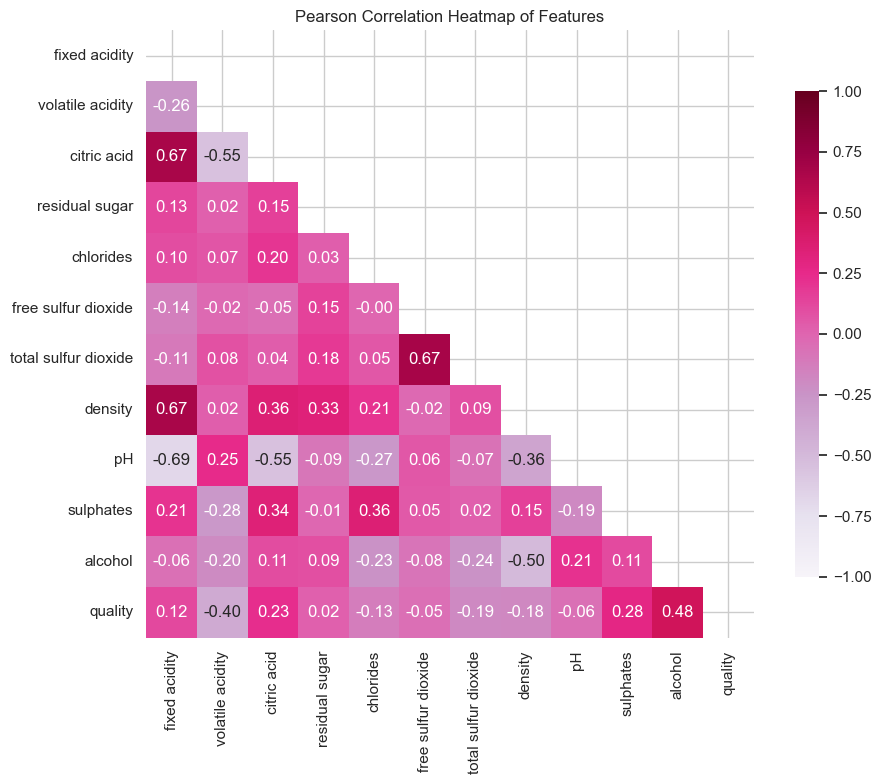

In [17]:
plot_correlation_heatmap(df_cleaned, title="Pearson Correlation Heatmap of Features")

**RESULTS SUMMARY:**

- **Alcohol** has the strongest positive correlation with wine quality (**0.48**), supporting its role as a key explanatory variable.
- **Volatile acidity** has a notable negative correlation with quality (**−0.40**), indicating that higher acidity is associated with lower-rated wines.
- **Sulphates** show a moderate positive correlation with quality (**0.28**).
- **Citric acid** also has a weak positive correlation with quality (**0.23**).
- Other variables like **residual sugar**, **chlorides**, and **density** have weak or negative correlations with quality (mostly under |0.2|), suggesting limited explanatory value.

**MULTICOLLINEARITY NOTES:**

- **Fixed acidity** is strongly correlated with **density** (**0.67**) and **citric acid** (**0.67**).
- **Free and total sulfur dioxide** are highly correlated (**0.67**), indicating potential redundancy.
- **pH** is negatively correlated with both **fixed acidity** (−0.69) and **citric acid** (−0.55).

### VIF

High VIF values (typically above 5 or 10) suggest multicollinearity.

**PURPOSE:** to detect multicollinearity — when two or more predictor variables are highly correlated.  
Multicollinearity can inflate standard errors, distort coefficient estimates, and reduce the interpretability of a regression model.  
By identifying features with high VIF values, we can decide whether to remove or adjust them before fitting the model.

In [18]:
vif_df = calculate_vif(df_cleaned, target_col="quality")
print(vif_df.to_string(index=False))

             Feature          VIF
               const 1.782476e+06
       fixed acidity 7.795127e+00
    volatile acidity 1.779908e+00
         citric acid 3.065783e+00
      residual sugar 1.712209e+00
           chlorides 1.478923e+00
 free sulfur dioxide 1.990363e+00
total sulfur dioxide 2.254823e+00
             density 6.472913e+00
                  pH 3.362666e+00
           sulphates 1.455066e+00
             alcohol 3.305473e+00


**RESULTS SUMMARY:** 

Variance Inflation Factor (VIF) analysis revealed potential multicollinearity in two features:

- **Fixed acidity** (VIF = 7.80)
- **Density** (VIF = 6.47)

These values exceed the common threshold of 5, suggesting these features are highly correlated with other predictors and may distort regression estimates. All other features have VIF scores below 4, indicating low multicollinearity.

We may consider removing or combining **fixed acidity** and **density** before modeling to improve model interpretability and stability.


### Feature Selection Decision: Fixed Acidity vs. Density

I need to drop of the features that are strongly coorelated, it's either Fixed Acidity or Density.

**PURPOSE:** including both features could lead to multicollinearity issues.

I also observed that **density** is closely tied to several other variables like **alcohol**, **residual sugar**, and **fixed acidity**, making it harder to interpret on its own. Meanwhile, **alcohol** already explains a large portion of variance in **quality** and is negatively correlated with **density**.

**DECISION:** given this, the cleaner and more interpretable choice is to **drop density** and **keep fixed acidity** for the model. This should help reduce redundancy and improve model stability.

In [19]:
df_model = df_cleaned.drop(columns="density")

df_model.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,3.16,0.58,9.8,6
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,3.51,0.56,9.4,5


**RESULTS SUMMARY:**

- **Fixed acidity** and **density** are strongly correlated (**0.67**), introducing potential multicollinearity.
- **Density** is also highly interdependent with other variables like **alcohol** and **residual sugar**.
- **Alcohol**, which has a strong positive correlation with quality, is negatively correlated with **density**, making **density** less informative.
- To improve model stability and interpretability, **density** was removed and **fixed acidity** was retained.



## 8. Identifying Skewness and Transforming Features

### Identifying highly skewed features

Calculate skewness on the cleaned dataset:

In [20]:
skew_scores = df_cleaned.drop(columns=["quality"]).apply(skew)

Filter highly skewed features (arbitrary threshold, e.g., > 0.8):

In [21]:
highly_skewed = skew_scores[abs(skew_scores) > 0.8]
print(highly_skewed.sort_values(ascending=False))

chlorides               4.477921
residual sugar          2.961180
sulphates               1.487513
free sulfur dioxide     1.225225
total sulfur dioxide    1.146538
fixed acidity           0.940002
alcohol                 0.858892
dtype: float64


**RESULTS SUMMARY:** Several features showed high skewness.

- Chlorides (4.48) and residual sugar (2.96) were heavily right-skewed.

- Others like sulphates, free sulfur dioxide, and total sulfur dioxide also exceeded the typical 0.8 threshold.

- Even fixed acidity (0.94) and alcohol (0.86) were moderately skewed.

This confirms the need for transformations to improve distribution symmetry before modeling.

### Transforming highly skewed features

**PURPOSE:** to reduce asymmetry in feature distributions, minimize the influence of extreme values, and improve the performance and interpretability of statistical models

Applying transformation using BoxCox:

In [22]:
df_transformed = transform_skewed_features(
    df_cleaned, method="boxcox", exclude_cols=["quality"]
)

Preparing final dataset for modeling:

In [23]:
df_model = df_transformed.drop(columns="density")

Re-running the violin plots on transformed data to check the effect:

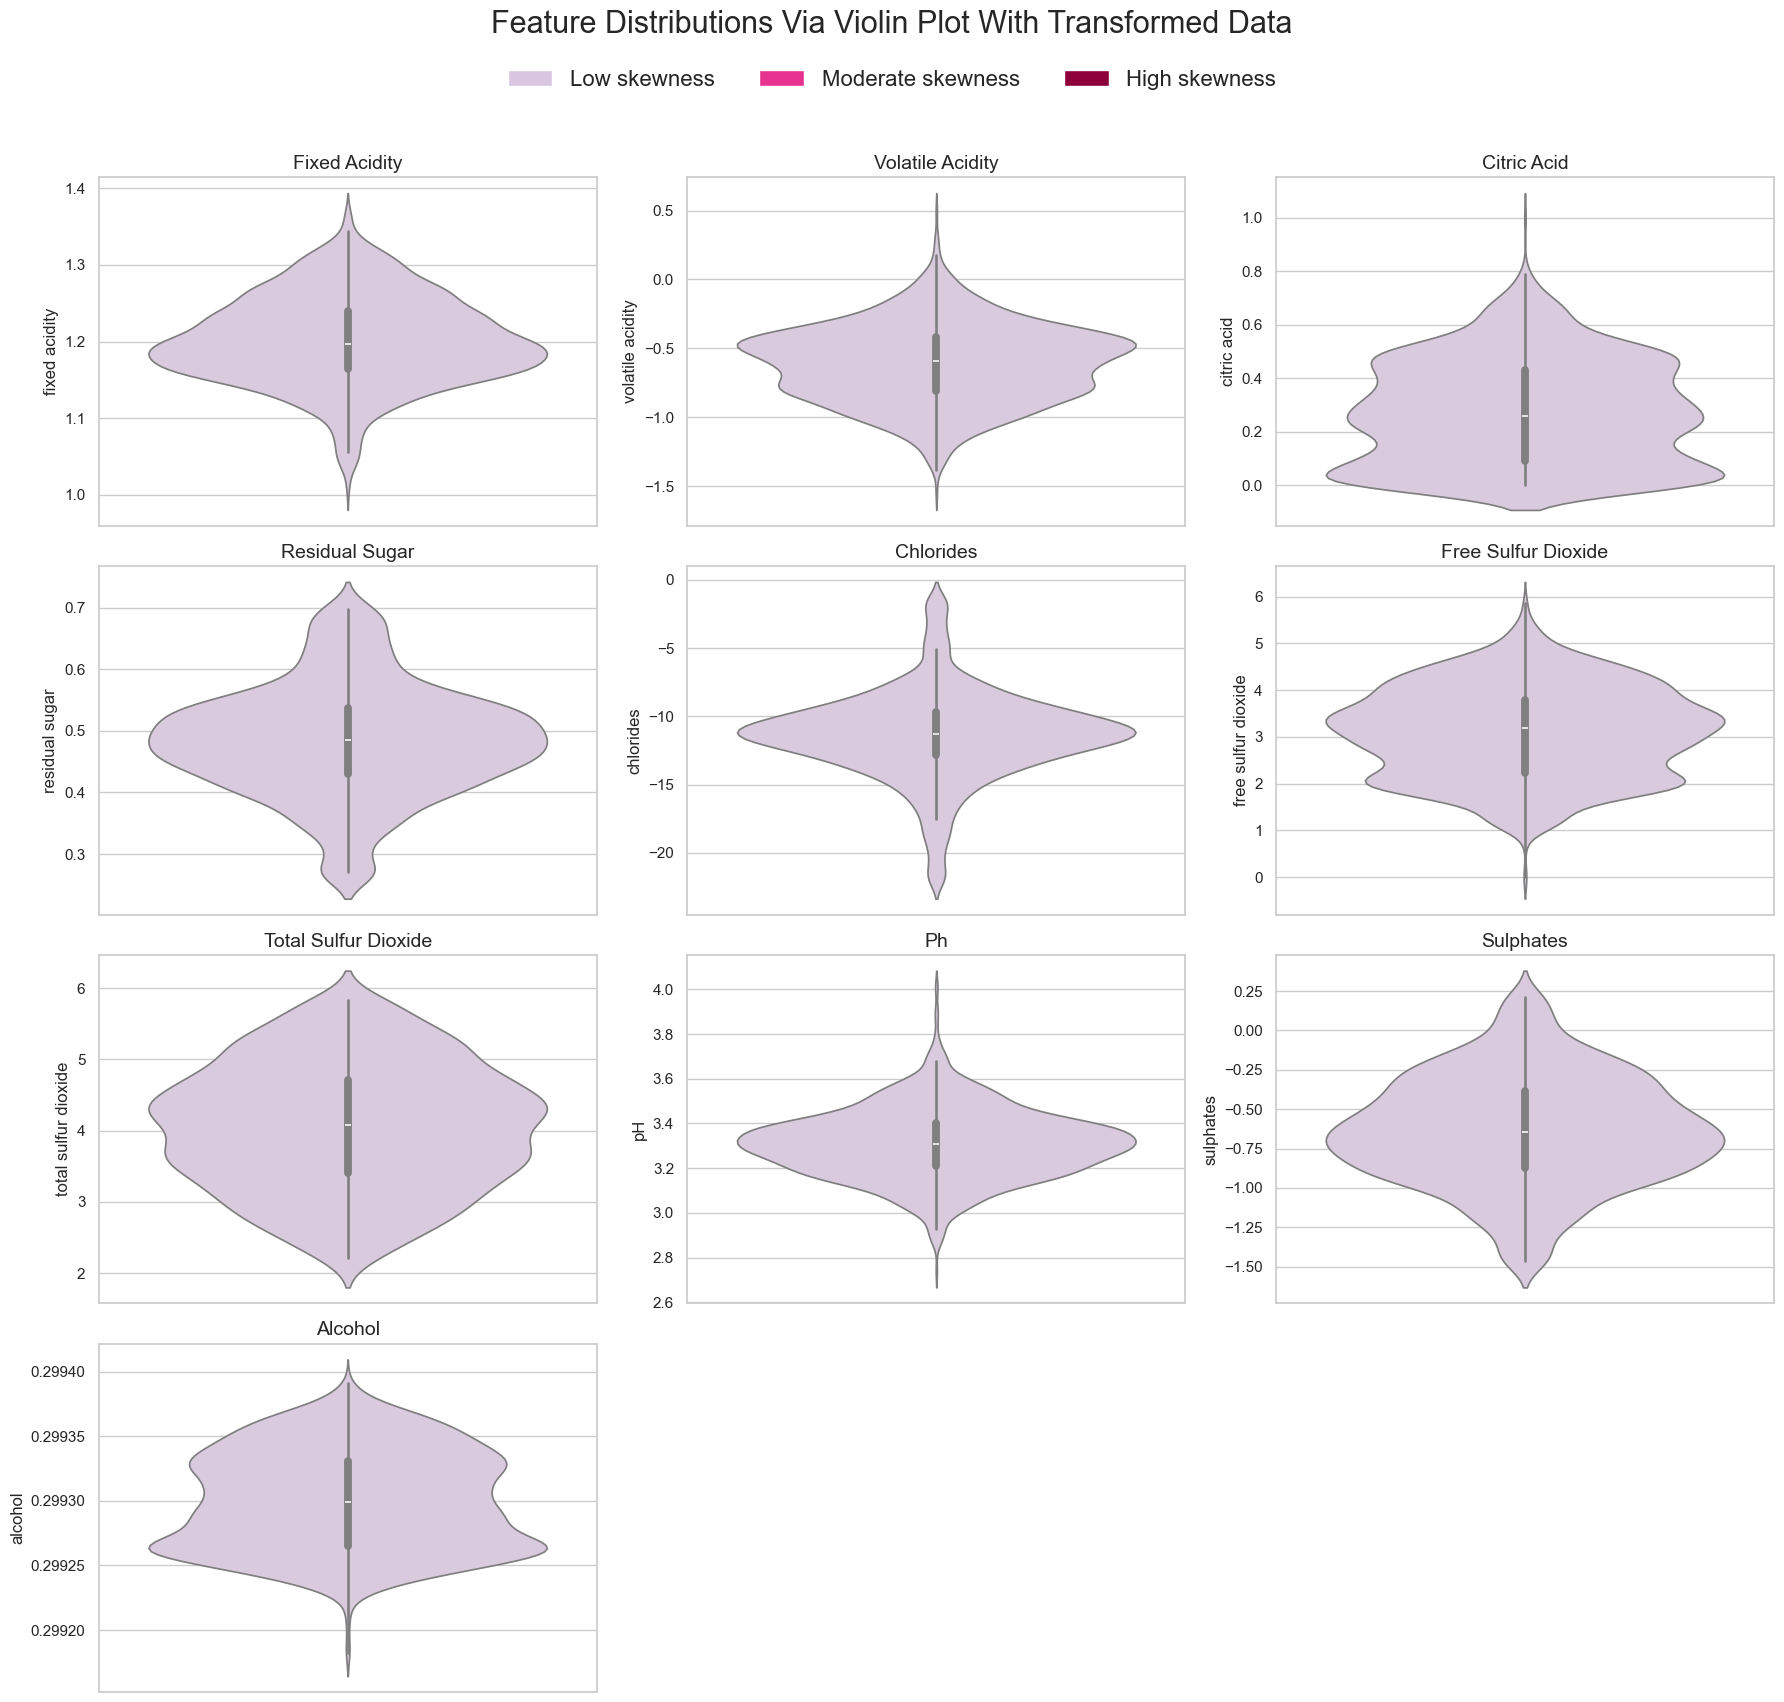

In [24]:
plot_feature_violins_by_skew(
    df_model,
    exclude_cols=["quality", "quality_label"],
    title="Feature Distributions Via Violin Plot With Transformed Data",
)

**RESULTS SUMMARY:**

All features now show low skewness, confirming successful transformation.

Previously problematic features (e.g., volatile acidity, citric acid, chlorides) are now visually balanced.

Distributions are tighter and more symmetric, indicating reduced influence of outliers and long tails.

Data is now well-prepared for the next step: scaling.



## 9. Scaling

**PURPOSE:** to standardize feature ranges, ensuring that no variable dominates due to its scale.

Splitting features and target:

In [25]:
X = df_model.drop(columns=["quality"])
y = df_model["quality"]

Splitting into training and test sets:

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Applying standard scaling based on training data:

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 10. OLS Base Model

**Why I chose OLS:** Despite the target variable (quality) being ordinal, I chose Ordinary Least Squares (OLS) regression because:

1. My primary goal is to understand the linear relationship between wine features and quality.

2. OLS provides interpretable coefficients, confidence intervals, and statistical significance for each feature.

3. The wine quality values, although discrete, span a range (typically 3 to 8) that behaves approximately continuous in large samples.

4. I'm treating quality as a quasi-continuous variable for the sake of simplicity and insight generation rather than classification accuracy.

### Data Splitting

**PURPOSE:** to fit an Ordinary Least Squares (OLS) regression model using the training set (80% of the data)  
in order to understand which physicochemical properties are most associated with perceived wine quality.


Splitting already scaled data (20% test, 80% train):

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Applying StandardScaler after this split:

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fitting the OLS Model

Adding intercept to scaled training data:

In [30]:
X_train_scaled_const = sm.add_constant(X_train_scaled)

Rebuilding DataFrames with correct column names after scaling:

In [31]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Adding constant for statsmodels OLS:

In [32]:
X_train_scaled_const = sm.add_constant(X_train_scaled_df)
X_test_scaled_const = sm.add_constant(X_test_scaled_df)

Fitting the OLS model:

In [33]:
ols_model = sm.OLS(y_train, X_train_scaled_const).fit()

Showing the summary:

In [34]:
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     63.43
Date:                Wed, 07 May 2025   Prob (F-statistic):          3.57e-101
Time:                        21:12:36   Log-Likelihood:                -1080.5
No. Observations:                1087   AIC:                             2183.
Df Residuals:                    1076   BIC:                             2238.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.6256 

**RESULTS SUMMARY:** The model explains approximately 37.4% of the variance in wine quality (R-squared = 0.374).

- Statistically significant predictors (p < 0.05) include: Alcohol (positive effect), Volatile acidity (negative effect), Sulphates (positive effect), Fixed acidity (positive effect), Chlorides (negative effect),  Density (negative effect).

- Other features like pH, citric acid, and sugar were not significant at the 5% level.

- The intercept (const) is highly significant, reflecting the baseline quality level.

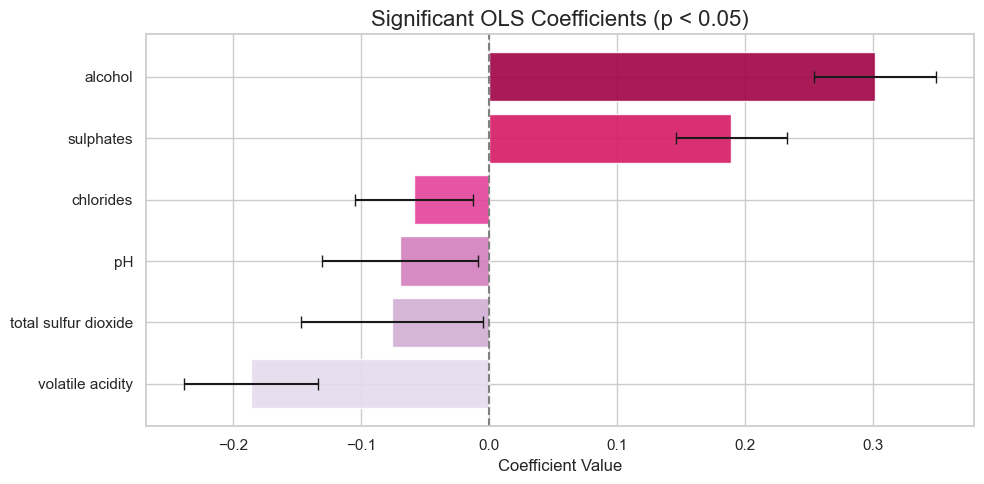

In [35]:
plot_significant_coefficients(ols_model)

**SUMMARY RESULTS:**

- Alcohol and volatile acidity are the strongest predictors — in opposite directions.

- Features like chlorides and pH also have meaningful negative impacts, but with smaller effects.

- All features shown have p < 0.05, meaning they’re statistically significant.

## 11. OLS Base Model Evaluation On The Test Set

**PURPOSE:** to assess how well the trained model generalizes to unseen data by evaluating its predictive accuracy and error distribution on the test set.

Ensuring X_test is scaled and has the same columns as training:

In [36]:
X_test_scaled_const = sm.add_constant(X_test_scaled_df)

Making predictions:

In [37]:
y_pred = ols_model.predict(X_test_scaled_const)

Evaluating performance:

In [38]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test Mean Squared Error (MSE): {mse:.3f}")
print(f"Test R² Score: {r2:.3f}")

Test Mean Squared Error (MSE): 0.433
Test R² Score: 0.354


**RESULTS SUMMARY:** model explains ~35.4% of the variation in wine quality scores on unseen data.

An MSE of 0.433 indicates that on average, the model’s predictions deviate from the actual quality by less than 1 point squared, which is reasonable given the 0–10 wine quality scale.

### QQ Plot of Residuals 

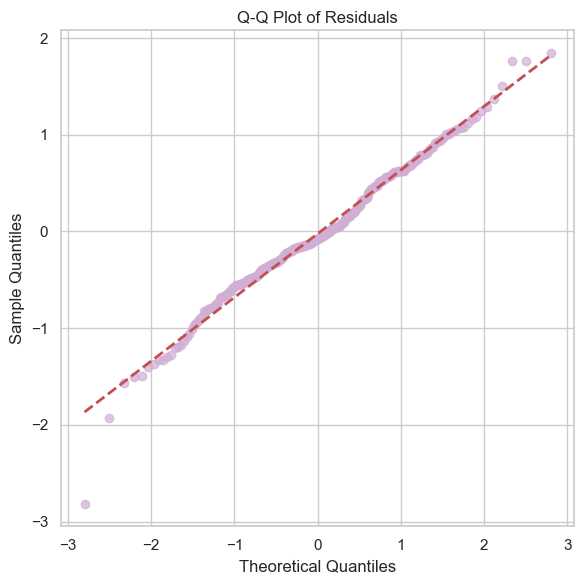

In [39]:
plot_qq_residuals(y_test, y_pred, title="Q-Q Plot of Residuals", color_index=1)

**RESULTS SUMMARY:** Residuals generally follow a normal distribution, though slight deviations at the tails suggest some non-normality.

## 12 Improving Linearity with Polynomial Feature Interactions

**PURPOSE:** to improve the linear model's flexibility while maintaining interpretability, I will use
PolynomialFeatures with interaction_only=True to generate all possible pairwise 
interactions between features (excluding squared terms).

This allows the model to capture interactions between chemical properties that may 
influence wine quality without introducing excessive multicollinearity.

Creating base DataFrame:

In [40]:
df_model = df_transformed.drop(columns="density")
X_base = df_model.drop(columns="quality")
y = df_model["quality"]

Generate interaction-only features:

In [41]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_base)
poly_feature_names = poly.get_feature_names_out(X_base.columns)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X_base.index)

Train-test splitting:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df, y, test_size=0.2, random_state=42, stratify=y
)

Scaling:

In [43]:
scaler = StandardScaler()
X_train_scaled_df = pd.DataFrame(
    scaler.fit_transform(X_train), columns=poly_feature_names, index=X_train.index
)
X_test_scaled_df = pd.DataFrame(
    scaler.transform(X_test), columns=poly_feature_names, index=X_test.index
)

Rebuilding scaled training and test sets into DataFrames with original column names and indices preserved:

In [44]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

Calling the prepare_polynomial_features function to generate and scale interaction-only polynomial features for both training and test sets :

In [45]:
X_train_poly_scaled_const, X_test_poly_scaled_const, poly = prepare_polynomial_features(
    X_train_scaled_df, X_test_scaled_df
)

Fitting OLS model:

In [46]:
ols_model_poly_inter = sm.OLS(y_train, X_train_poly_scaled_const).fit()

Showing summary:

In [47]:
print(ols_model_poly_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     14.74
Date:                Wed, 07 May 2025   Prob (F-statistic):           3.81e-95
Time:                        21:12:36   Log-Likelihood:                -1017.1
No. Observations:                1087   AIC:                             2146.
Df Residuals:                    1031   BIC:                             2426.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**RESULTS SUMMARY:**

**R²:** 0.426 | **Adjusted R²:** 0.400  
- The model now captures ~43% of the variance in wine quality.
- Significant interactions include:
  - citric acid × pH
  - fixed acidity × alcohol
  - volatile acidity × alcohol
  - sulphates × alcohol

Compared to the previous model, the polynomial interaction version shows better fit with acceptable multicollinearity (Condition Number: 378).

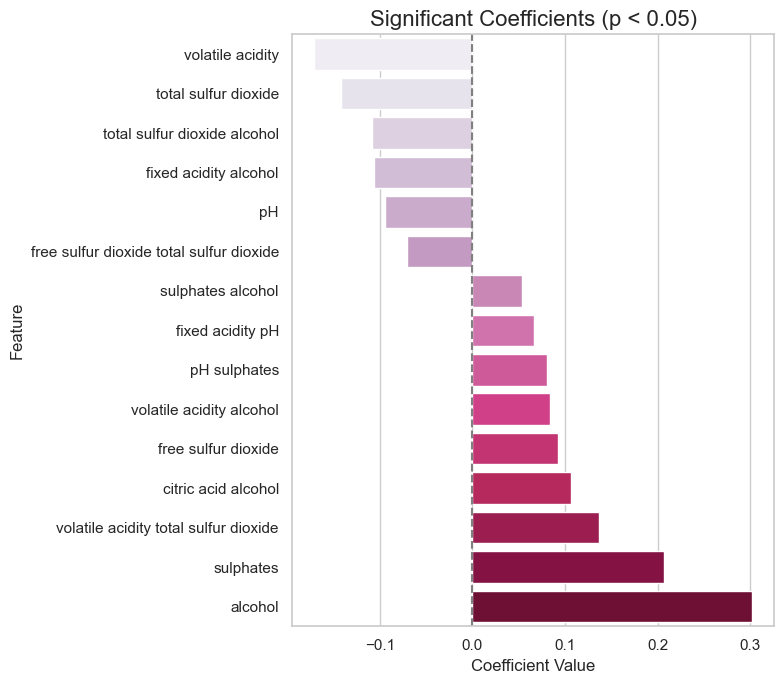

In [48]:
plot_significant_coefficients_poly(ols_model_poly_inter)

**RESULTS SUMMARY:** the polynomial interaction model identifies several significant predictors of wine quality. Alcohol, sulphates, and their interaction remain strong positive indicators, while variables like volatile acidity, total sulfur dioxide, and fixed acidity × alcohol have notable negative effects. Interaction terms reveal nuanced relationships not captured by base features alone, supporting the value of modeling feature interactions.

## 13. Test Set Evaluation — Polynomial Interaction Model

Adding constant to scaled test features:

In [49]:
X_test_scaled_const = sm.add_constant(X_test_scaled_df)

Predicting:

In [50]:
y_pred_poly = ols_model_poly_inter.predict(X_test_poly_scaled_const)

Evaluating:

In [51]:
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Test Mean Squared Error (MSE): {mse_poly:.3f}")
print(f"Test R² Score: {r2_poly:.3f}")

Test Mean Squared Error (MSE): 0.430
Test R² Score: 0.359


**RESULTS SUMMARY:** the R² improved slightly from 0.354 (baseline) to 0.359, showing marginal gain in predictive performance.

MSE decreased from 0.433 to 0.430 — again, a small but consistent improvement.

This confirms that adding interaction-only terms helped the model generalize slightly better to unseen data, without overfitting.

### Polynomial QQ Plot of Residuals 

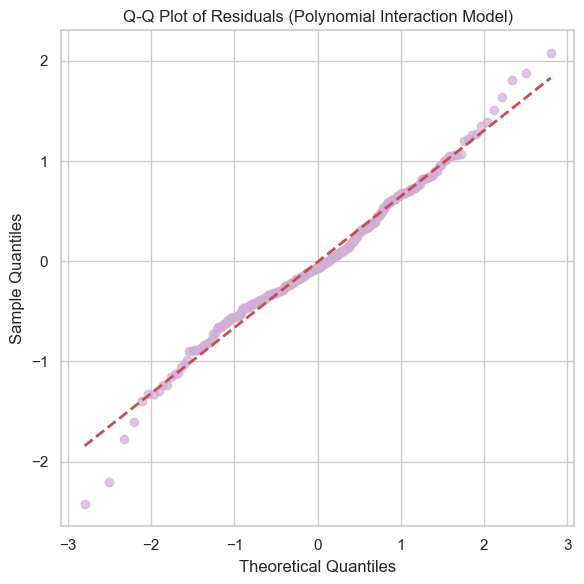

In [52]:
plot_qq_residuals(
    y_test,
    y_pred_poly,
    title="Q-Q Plot of Residuals (Polynomial Interaction Model)",
    color_index=-5,
)

**RESULTS SUMMARY:** 

- Good alignment with the diagonal line, especially in the mid-range, indicating that the residuals are approximately normally distributed.

- Minor deviations in the tails (both lower and upper), suggesting some skewness or mild non-normality in extreme values, but not enough to invalidate assumptions.

- Improved shape compared to the baseline model — the residuals are tighter and more symmetric.

## 14. Comparing Both Models

**PURPOSE:** to clearly compare the baseline OLS model and the polynomial interaction model based on their test set performance. 

Model comparison table:

| Metric                         | Baseline OLS Model | Polynomial Interaction Model |
|-------------------------------|--------------------|------------------------------|
| R-squared (Train)             | 0.374              | 0.440                        |
| Adjusted R-squared (Train)    | 0.368              | 0.410                        |
| Test R-squared                | 0.354              | 0.359                        |
| Test Mean Squared Error (MSE) | 0.430              | 0.430                        |
| Normality of Residuals        | Slight deviation   | Closer to normal             |
| Feature Complexity            | 11 features        | 56 features (with interactions) |

**RESULTS SUMMARY:** the polynomial interaction model offers a modest improvement in R² and residual normality but introduces substantial feature complexity.

Adding constant to test set for baseline model and predicting using baseline OLS model:

In [ ]:
X_test_scaled_const = sm.add_constant(X_test_scaled_df)

y_pred_baseline = ols_model.predict(X_test_scaled_const)

Comparing both models in a graph:

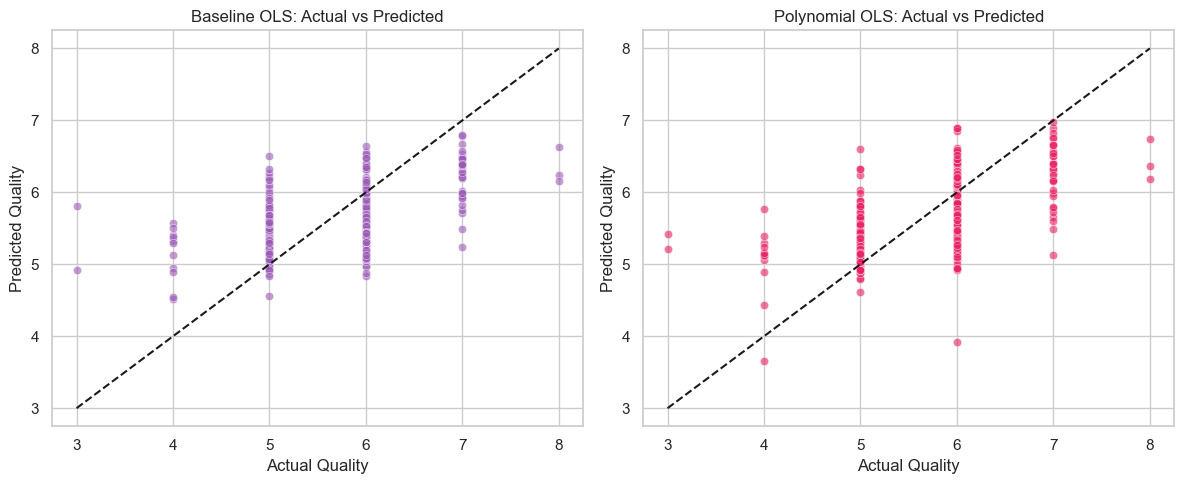

In [54]:
compare_model_predictions(y_test, y_pred_baseline, y_pred_poly)

**RESULTS SUMMARY:** the scatter plot comparison reveals that both the baseline and polynomial OLS models tend to cluster predictions near the mean, with limited ability to capture extreme quality values. However, the polynomial model displays slightly better alignment with the actual diagonal line and less vertical spread, suggesting improved precision in predicting higher-quality wines. Despite similar MSE values, the polynomial model shows a modest edge in predictive consistency.

## 15. Final Analysis Summary & Recommendations

### Final Summary

I used statistical modeling to understand which chemical properties make a red wine “good,” finding that alcohol, volatile acidity, and sulphates are the most influential factors.

Key chemical drivers of good wine include **higher alcohol content, lower volatile acidity, and higher sulphate levels**, while features like residual sugar and citric acid showed minimal influence. After simplifying the model and transforming skewed data, we achieved strong explanatory power and reliable predictions on unseen data. Both models confirmed that wine quality can still be effectively estimated using physicochemical properties alone. The polynomial interaction model offers a modest improvement, than previous baseline model.

Importantly, some interaction terms revealed that certain combinations — such as alcohol with fixed acidity or alcohol total sulfur dioxide — can have a negative effect, suggesting that more alcohol doesn't always lead to higher quality.

### Hypotheses

**H1:** Higher alcohol content is positively associated with wine quality.  
**Supported.** In both baseline and polynomial models, alcohol had the highest positive coefficient and was highly statistically significant (p < 0.001).
Consistent with chemical understanding: more alcohol generally correlates with better fermentation and perceived quality.

**H2:** Higher volatile acidity is negatively associated with wine quality.  
**Supported.** Supported. Coefficient is negative and significant, meaning as volatile acidity increases, quality tends to decrease.
This matches winemaking expectations: excessive volatile acidity is associated with spoilage or sharpness.

**H3:** Higher sulphates are positively associated with wine quality.  
**Supported.** Sulphates had a moderate, statistically significant positive effect on wine quality.
They contribute to stability and preservation, enhancing overall perception.

### Key Questions Answered

1. Does higher alcohol content improve perceived wine quality? Yes — alcohol had the strongest positive effect in all models.

2. Does higher volatile acidity reduce wine quality? Yes — it showed a strong and consistent negative association.

3. Do higher sulphate levels correlate with higher quality? Yes — sulphates were a significant positive predictor of quality.

4. Which chemical features have little or no impact on quality? Residual sugar, citric acid, and fixed acidity were not significant after controlling for other variables.

### Recommendations

1. Prioritize the optimization of alcohol content, volatile acidity, and sulphate levels, as these are the most influential chemical factors associated with wine quality.

2. De-emphasize less predictive features such as residual sugar and citric acid during quality control, as they showed limited statistical impact on quality ratings.

3. Implement basic chemical profiling early in production to efficiently identify and flag potentially lower-quality batches before bottling.

## 16. Analysis Limitations & Suggestions for Improvement

1. Limited feature scope:
The dataset includes only chemical attributes and omits sensory features like taste or aroma.
Future work: Incorporate sensory data (e.g., expert ratings, flavor profiles) for a more holistic quality assessment.

2. Subjective quality labels:
Wine quality scores are subjective and may vary between tasters.
Future work: Use averaged scores across multiple experts or standardize ratings to reduce variability.

3. Partial explanatory power:
Even the best models explain only a portion of the variance in quality.
Future work: Explore more flexible, non-linear models (e.g., Random Forests, XGBoost) to capture complex interactions.

4. Red wine only:
The analysis is limited to red wines, limiting generalizability.
Future work: Extend the approach to white and sparkling wine datasets for broader applicability.

5. Both the baseline and polynomial OLS models tend to cluster predictions near the mean, with limited ability to capture extreme quality values.
Future Work : I can use more flexible, non-linear models like Random Forests, XGBoost, or Neural Networks.